# Data Ingestion via APIs

*Further Reading*

- Foundations of Data Engineering, by Reis and Housley (Chapter 7)
- [Getting started with SODA consumer API](https://dev.socrata.com/consumers/getting-started.html)

*Additional Helpful Packages*

- [`requests`](https://pypi.org/project/requests/) for working with directly with HTTP requests.
- [`ratelim`](https://pypi.org/project/ratelim/) for limiting the number of times a function can be called.
- [`tenacity`](https://pypi.org/project/tenacity/) for adding retry behaviour.
  

## Ingestion | Considerations

- Data size and velocity
  - Bounded vs. unbounded
  - Frequency
  - Batch vs. streaming
- Synchronous vs. asynchronous ingestion
- Push, pull, polling:
  - Push: Source _pushes_ data to downstream target
  - Pull: Target _pulls_ data from upstream source
  - Poll: Target periodically _polls_ for changes and pulls when there is new data

## What is an API
    
- API: Application Programming interface
- Provides a programmable means of communication between two applications.
- In this course, we are concerned with data APIs that communicate over the internet.
- Data APIs typical scenarios:
  - Data is changing quickly, e.g. stock prices
  - The whole dataset is not required, only transfer relevant data for downstream usage
  - Data is typically transferred in text-based formats such as XML or JSON. Other formats are also possible. 
  - Can be _stateful_ (e.g. streaming) or _stateless_ (e.g. REST)

## REST APIs

- Most APIs are RESTful, i.e. they provide a REST (REpresentational State Transfer) interface.

- REST uses standard HTTP commands encoded within a URL.

- It is stateless, everything related to a request must be encoded in the URL (e.g. authentication, queries)

- Handle typical CRUD (Create, Read, Update, Delete) operations for persistent storage via:
  - POST,
  - GET,
  - PUT, and
  - DELETE commands.

- GET will likely be the most commonly used command in downstream data applications.

## REST Examples

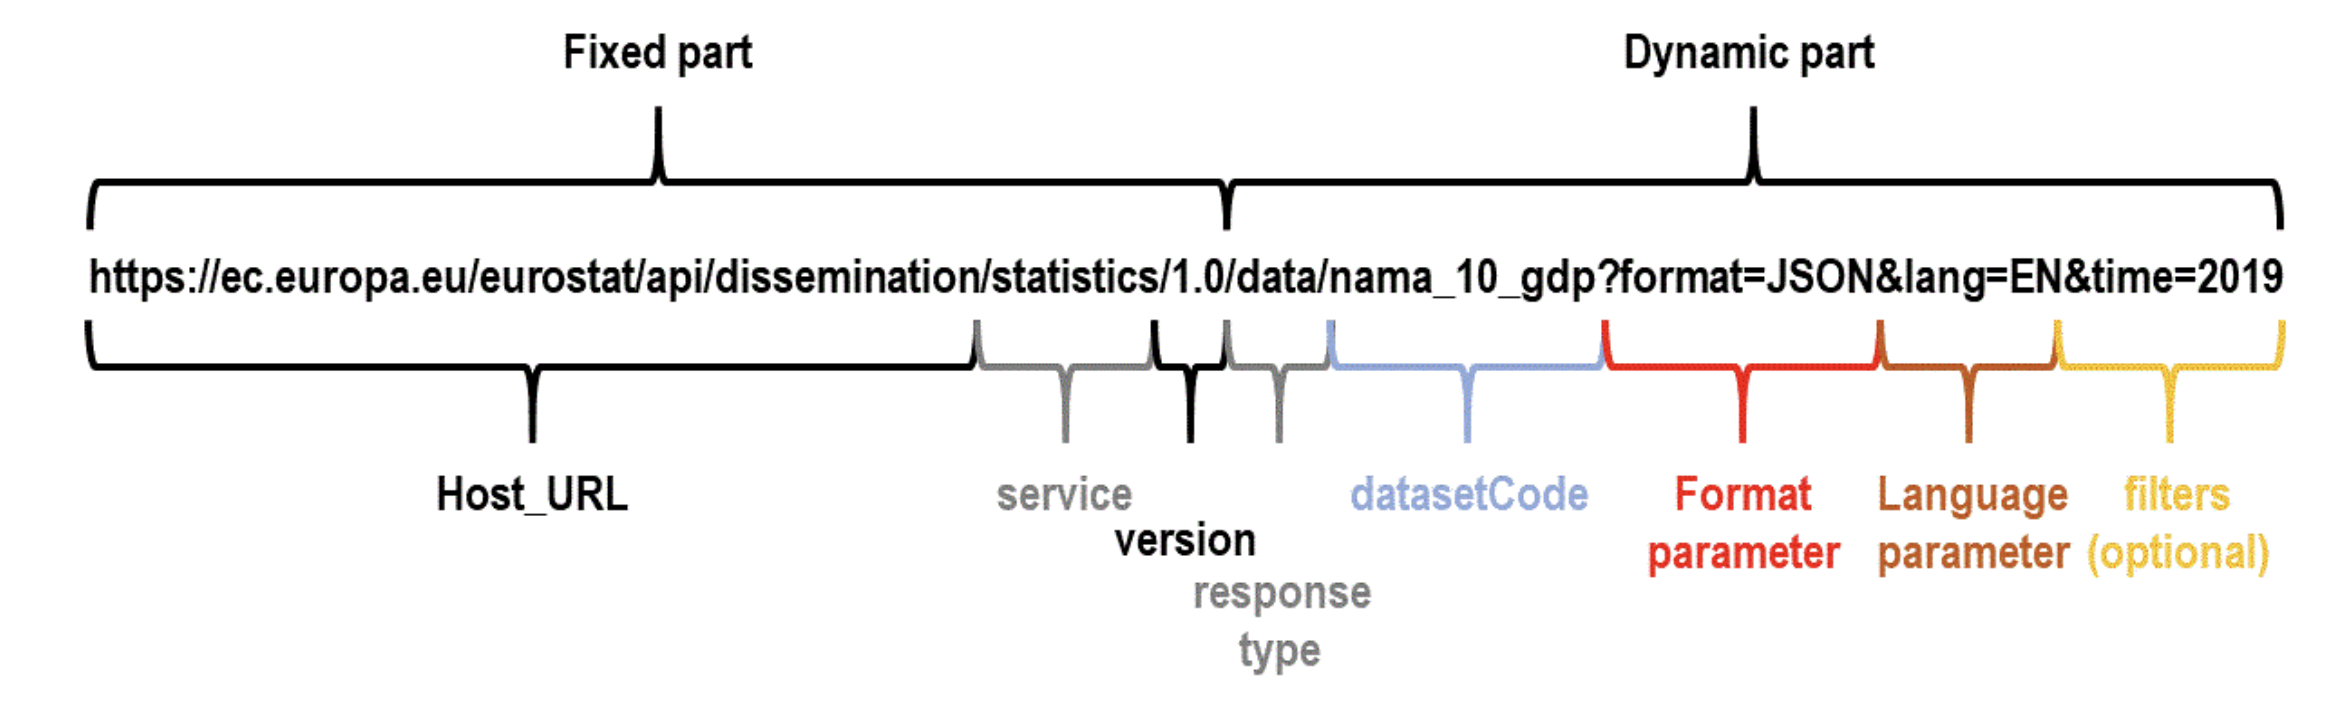

- [Eurostat API](https://wikis.ec.europa.eu/display/EUROSTATHELP/API+-+Getting+started+with+statistics+API)
- [Socrata Open DATA (SODA) API](https://dev.socrata.com/docs/endpoints.html)
  - Also look at [how to query more than 1000 rows](https://support.socrata.com/hc/en-us/articles/202949268-How-to-query-more-than-1000-rows-of-a-dataset)

In [1]:
# Let's access data via the SODA API provided by YYC Open Data Portal,
# (Socrata)

baseURL = 'https://data.calgary.ca/resource/crbp-innf.json'

# By default, the API returns 1000 records. Can request more by specifying a limit.
# For this data set, the following limit should be able to read the entire dataset.
# Be aware of API limits. Also, think about whether you need all the data or can 
# perhaps query/filter data at source.

params = '?$limit=400000' 
epURL = baseURL + params

In [2]:
import pandas as pd

In [3]:
# Read the data using pandas
cecDF = pd.read_json(epURL)

In [4]:
# Reading from the API should preserve schema
print(cecDF.info())
display(cecDF.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352157 entries, 0 to 352156
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   business_unit_desc  352157 non-null  object
 1   facilityname        352157 non-null  object
 2   site_id             352157 non-null  object
 3   facilityaddress     352157 non-null  object
 4   energy_description  352157 non-null  object
 5   year                352157 non-null  int64 
 6   month               352157 non-null  object
 7   total_consumption   352157 non-null  int64 
 8   unit                352157 non-null  object
dtypes: int64(2), object(7)
memory usage: 24.2+ MB
None


business_unit_desc          facilityname        site_id  \
0  Calgary Fire Department  ATCO VILLAGE (HOUSE)  0020003498361   
1  Calgary Fire Department  ATCO VILLAGE (HOUSE)  0020003498361   
2  Calgary Fire Department  ATCO VILLAGE (HOUSE)  0020003498361   
3  Calgary Fire Department  ATCO VILLAGE (HOUSE)  0020003498361   
4  Calgary Fire Department  ATCO VILLAGE (HOUSE)  0020003498361   

  facilityaddress energy_description  year month  total_consumption unit  
0   6015 23 AV SE        Electricity  2014   Apr               1107  Kwh  
1   6015 23 AV SE        Electricity  2014   Aug               1130  Kwh  
2   6015 23 AV SE        Electricity  2014   Dec               1775  Kwh  
3   6015 23 AV SE        Electricity  2014   Feb               2320  Kwh  
4   6015 23 AV SE        Electricity  2014   Jan               1883  Kwh

facilityname  SUM_total_consumption
0                   CALGARY STREET LIGHTING               43073474
1            BEARSPAW WATER TREATMENT PLANT               36443236
2      BONNYBROOK WWTP UTILITY BUILDING 'B'               26875883
3            GLENMORE WATER TREATMENT PLANT               20840956
4     PINE CREEK WASTEWATER TREATMENT PLANT               19836870
...                                     ...                    ...
1004                                 COV106                      1
1005  HIL056 - RILEY PARK; RILEY PARK DEPOT                      1
1006                                 PAN030                      0
1007                                 TUS643                      0
1008                  RICHMOND GREEN GARAGE                      0

[1009 rows x 2 columns]

<Axes: xlabel='facilityname'>

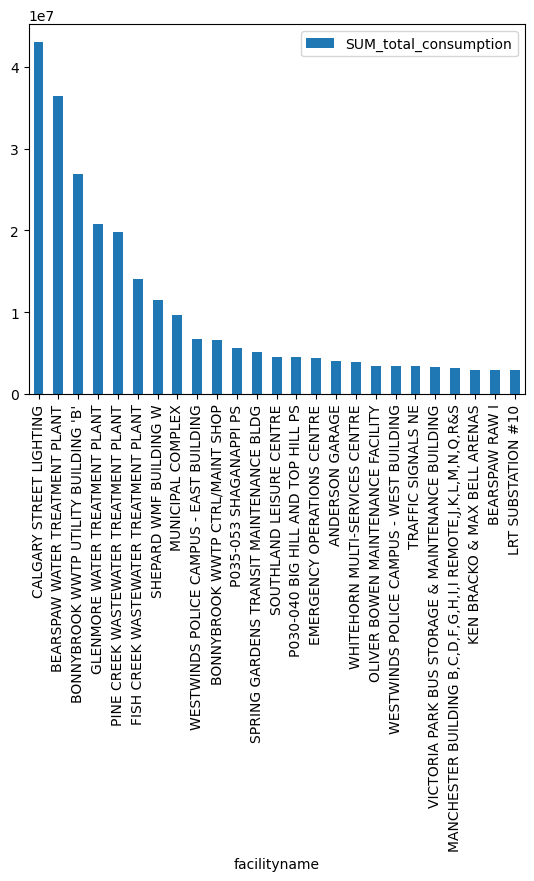

In [5]:
# In data-intensive applications, we don't want to be moving a lot of data around. 
# We should filter data at the source and ingest only what's needed.
# SODA provides filtering operations for this via SODA Query Language (SoQL)

# Example: Total consumption for a particular year grouped by facility

filter = '&$select=facilityname,SUM(total_consumption)&year=2023&unit=Kwh&$group=facilityname&$order=SUM_total_consumption%20DESC'
filterDF = pd.read_json(epURL + filter)
display(filterDF)

# Plot Top 25 consumers
filterDF = filterDF.head(25).set_index('facilityname')
filterDF.plot(kind='bar')